In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

plt.rcParams["font.family"] = "serif"

In [2]:
def compute_coverage_probs(true_values, ci_lower, ci_upper):
    """Compute empirical coverage probabilities.
    
    Args:
        true_values: Ground truth values, shape (n_samples,)
        ci_lower: Lower bounds of credible intervals, shape (n_samples, n_confidence_levels)
        ci_upper: Upper bounds of credible intervals, shape (n_samples, n_confidence_levels)
    
    Returns:
        Coverage probabilities for each confidence level, shape (n_confidence_levels,)
    """
    coverage = (ci_lower <= true_values.unsqueeze(-1)) * (true_values.unsqueeze(-1) <= ci_upper)
    return coverage.float().mean(0)

In [3]:
def plot_coverage_probs(confidence_levels, shear1_coverage_probs, shear2_coverage_probs, save_path=None):
    """Plot nominal vs empirical coverage probabilities.
    
    Args:
        confidence_levels: Nominal confidence levels
        shear1_coverage_probs: Empirical coverage for shear1
        shear2_coverage_probs: Empirical coverage for shear2
        save_path: Optional path to save the figure
    """
    fig, ax = plt.subplots(1, 2, figsize=(7, 3))
    fontsize = 14
    ticklabelsize = 8
    color = "#1c692b"
    s = 40

    _ = ax[0].axline((0, 0), slope=1, linestyle="dotted", color="black", linewidth=1, zorder=0)
    _ = ax[0].scatter(confidence_levels, shear1_coverage_probs, color=color, s=s, zorder=1)
    _ = ax[0].set_title(r"$\gamma_1$", fontsize=16)
    _ = ax[0].set_xlabel("Nominal coverage", fontsize=fontsize)
    _ = ax[0].xaxis.set_label_coords(1.2, -0.15)
    _ = ax[0].set_ylabel("Empirical coverage", fontsize=fontsize)
    _ = ax[0].tick_params(axis="both", which="major", labelsize=ticklabelsize)
    _ = ax[0].set_xlim(0, 1)
    _ = ax[0].set_ylim(0, 1)

    _ = ax[1].axline((0, 0), slope=1, linestyle="dotted", color="black", linewidth=1, zorder=0)
    _ = ax[1].scatter(confidence_levels, shear2_coverage_probs, color=color, s=s, zorder=1)
    _ = ax[1].set_title(r"$\gamma_2$", fontsize=16)
    _ = ax[1].tick_params(axis="both", which="major", labelsize=ticklabelsize)
    _ = ax[1].set_xlim(0, 1)
    _ = ax[1].set_ylim(0, 1)

    for a in ax.flat:
        _ = a.spines[["top", "right"]].set_visible(False)

    _ = fig.subplots_adjust(wspace=0.4)

    if save_path is not None:
        fig.savefig(
            save_path,
            dpi=600,
            transparent=True,
            bbox_inches="tight",
            pad_inches=0,
        )

In [4]:
def plot_credible_intervals(
    shear1_true, shear2_true,
    shear1_ci_lower, shear1_ci_upper,
    shear2_ci_lower, shear2_ci_upper,
    interval_idx=17, n_display=1000, seed=0, save_path=None
):
    """Plot credible intervals showing coverage.
    
    Args:
        shear1_true: Ground truth shear1 values
        shear2_true: Ground truth shear2 values
        shear1_ci_lower: Lower bounds for shear1 CIs
        shear1_ci_upper: Upper bounds for shear1 CIs
        shear2_ci_lower: Lower bounds for shear2 CIs
        shear2_ci_upper: Upper bounds for shear2 CIs
        interval_idx: Index of confidence level to plot (default 17 = 90%)
        n_display: Number of samples to display
        seed: Random seed for sample selection
        save_path: Optional path to save the figure
    """
    fig, ax = plt.subplots(1, 2, figsize=(7, 3))
    fontsize = 14
    ticklabelsize = 8
    color = np.array(["#c26d27", "#1c692b"])
    alpha = 0.5
    axmin = -0.06
    axmax = 0.06

    np.random.seed(seed)
    n_samples = len(shear1_true)
    indexes = np.random.choice(n_samples, n_display, replace=False)

    # Shear 1
    _ = ax[0].axline((0, 0), slope=1, linestyle="dotted", color="black", linewidth=1)
    shear1_coverage = (
        (shear1_ci_lower <= shear1_true.unsqueeze(-1)) * (shear1_true.unsqueeze(-1) <= shear1_ci_upper)
    )[..., interval_idx]

    covered_legend = False
    uncovered_legend = False
    for i in range(len(indexes)):
        label = None
        if shear1_coverage[indexes[i]] and not covered_legend:
            covered_legend = True
            label = "covers"
        elif not shear1_coverage[indexes[i]] and not uncovered_legend:
            uncovered_legend = True
            label = "does not cover"
        _ = ax[0].vlines(
            x=shear1_true[indexes[i]],
            ymin=shear1_ci_lower[..., interval_idx][indexes[i]],
            ymax=shear1_ci_upper[..., interval_idx][indexes[i]],
            alpha=alpha,
            color=color[shear1_coverage[indexes[i]]],
            label=label,
        )
    _ = ax[0].set_xlabel(r"$\gamma_1$", fontsize=fontsize)
    _ = ax[0].set_ylabel(r"Posterior interval", fontsize=fontsize)
    _ = ax[0].tick_params(axis="both", which="major", labelsize=ticklabelsize)

    # Shear 2
    _ = ax[1].axline((0, 0), slope=1, linestyle="dotted", color="black", linewidth=1)
    shear2_coverage = (
        (shear2_ci_lower <= shear2_true.unsqueeze(-1)) * (shear2_true.unsqueeze(-1) <= shear2_ci_upper)
    )[..., interval_idx]

    covered_legend = False
    uncovered_legend = False
    for i in range(len(indexes)):
        label = None
        if shear2_coverage[indexes[i]] and not covered_legend:
            covered_legend = True
            label = "covers"
        elif not shear2_coverage[indexes[i]] and not uncovered_legend:
            uncovered_legend = True
            label = "does not cover"
        _ = ax[1].vlines(
            x=shear2_true[indexes[i]],
            ymin=shear2_ci_lower[..., interval_idx][indexes[i]],
            ymax=shear2_ci_upper[..., interval_idx][indexes[i]],
            alpha=alpha,
            color=color[shear2_coverage[indexes[i]]],
            label=label,
        )
    _ = ax[1].set_xlabel(r"$\gamma_2$", fontsize=fontsize)
    _ = ax[1].tick_params(axis="both", which="major", labelsize=ticklabelsize)

    leg = ax[0].legend(loc="upper left", prop={"size": ticklabelsize})
    for lh in leg.legend_handles:
        lh.set_alpha(1)

    for a in ax.flat:
        _ = a.spines[["top", "right"]].set_visible(False)
        _ = a.set_xlim(axmin, axmax)
        _ = a.set_ylim(axmin, axmax)
        _ = a.set_xticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
        _ = a.set_yticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
        _ = a.tick_params(axis="both", which="major", labelsize=ticklabelsize)

    _ = fig.subplots_adjust(wspace=0.4)

    if save_path is not None:
        fig.savefig(
            save_path,
            dpi=600,
            transparent=True,
            bbox_inches="tight",
            pad_inches=0,
        )

### **Setting 1**

**Load ground truth and credible intervals:**

In [5]:
setting1 = torch.load("npe_credible_intervals_setting1.pt", weights_only=False)

confidence_levels = setting1["confidence_levels"]
shear1_true = setting1["shear1_true"]
shear2_true = setting1["shear2_true"]
shear1_ci_lower = setting1["shear1_ci_lower"]
shear1_ci_upper = setting1["shear1_ci_upper"]
shear2_ci_lower = setting1["shear2_ci_lower"]
shear2_ci_upper = setting1["shear2_ci_upper"]

**Compute empirical coverage**

In [6]:
shear1_coverage_probs = compute_coverage_probs(shear1_true, shear1_ci_lower, shear1_ci_upper)
shear2_coverage_probs = compute_coverage_probs(shear2_true, shear2_ci_lower, shear2_ci_upper)

In [7]:
for i, ci in enumerate(confidence_levels):
    print(
        f"Confidence level: {ci:.2f}, Shear 1: {shear1_coverage_probs[i]:.4f}, Shear 2: {shear2_coverage_probs[i]:.4f}"
    )

Confidence level: 0.05, Shear 1: 0.0531, Shear 2: 0.0425
Confidence level: 0.10, Shear 1: 0.1079, Shear 2: 0.0867
Confidence level: 0.15, Shear 1: 0.1603, Shear 2: 0.1275
Confidence level: 0.20, Shear 1: 0.2081, Shear 2: 0.1707
Confidence level: 0.25, Shear 1: 0.2583, Shear 2: 0.2120
Confidence level: 0.30, Shear 1: 0.3052, Shear 2: 0.2522
Confidence level: 0.35, Shear 1: 0.3588, Shear 2: 0.2942
Confidence level: 0.40, Shear 1: 0.4100, Shear 2: 0.3398
Confidence level: 0.45, Shear 1: 0.4624, Shear 2: 0.3835
Confidence level: 0.50, Shear 1: 0.5124, Shear 2: 0.4345
Confidence level: 0.55, Shear 1: 0.5622, Shear 2: 0.4806
Confidence level: 0.60, Shear 1: 0.6123, Shear 2: 0.5313
Confidence level: 0.65, Shear 1: 0.6628, Shear 2: 0.5807
Confidence level: 0.70, Shear 1: 0.7119, Shear 2: 0.6324
Confidence level: 0.75, Shear 1: 0.7600, Shear 2: 0.6886
Confidence level: 0.80, Shear 1: 0.8123, Shear 2: 0.7463
Confidence level: 0.85, Shear 1: 0.8554, Shear 2: 0.8033
Confidence level: 0.90, Shear 1

**Plot nominal vs. empirical coverage**

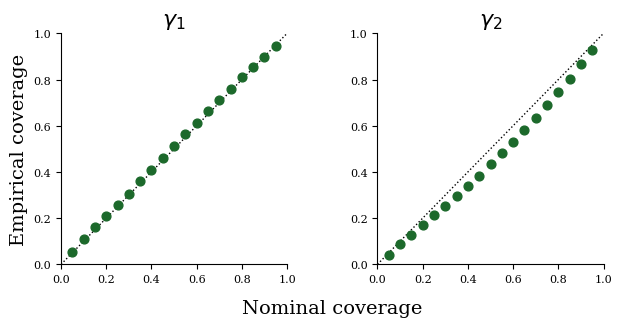

In [8]:
plot_coverage_probs(
    confidence_levels, shear1_coverage_probs, shear2_coverage_probs,
    save_path="figures/npe_coverageprobs_setting1.png"
)

**Plot 90% credible intervals**

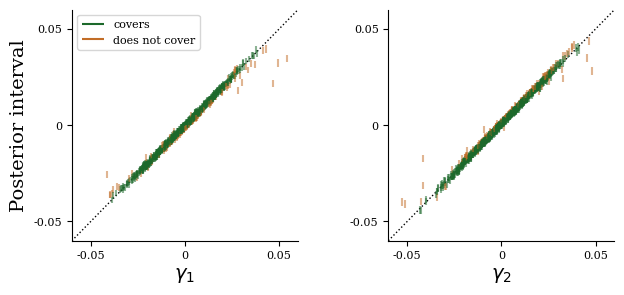

In [9]:
plot_credible_intervals(
    shear1_true, shear2_true,
    shear1_ci_lower, shear1_ci_upper,
    shear2_ci_lower, shear2_ci_upper,
    save_path="figures/npe_credibleintervals_setting1.png"
)

### **Setting 2**

In [10]:
setting2 = torch.load("npe_credible_intervals_setting2.pt", weights_only=False)

confidence_levels = setting2["confidence_levels"]
shear1_true = setting2["shear1_true"]
shear2_true = setting2["shear2_true"]
shear1_ci_lower = setting2["shear1_ci_lower"]
shear1_ci_upper = setting2["shear1_ci_upper"]
shear2_ci_lower = setting2["shear2_ci_lower"]
shear2_ci_upper = setting2["shear2_ci_upper"]

shear1_coverage_probs = compute_coverage_probs(shear1_true, shear1_ci_lower, shear1_ci_upper)
shear2_coverage_probs = compute_coverage_probs(shear2_true, shear2_ci_lower, shear2_ci_upper)

for i, ci in enumerate(confidence_levels):
    print(
        f"Confidence level: {ci:.2f}, Shear 1: {shear1_coverage_probs[i]:.4f}, Shear 2: {shear2_coverage_probs[i]:.4f}"
    )

Confidence level: 0.05, Shear 1: 0.0575, Shear 2: 0.0523
Confidence level: 0.10, Shear 1: 0.1116, Shear 2: 0.1056
Confidence level: 0.15, Shear 1: 0.1718, Shear 2: 0.1581
Confidence level: 0.20, Shear 1: 0.2328, Shear 2: 0.2084
Confidence level: 0.25, Shear 1: 0.2876, Shear 2: 0.2632
Confidence level: 0.30, Shear 1: 0.3467, Shear 2: 0.3176
Confidence level: 0.35, Shear 1: 0.4008, Shear 2: 0.3716
Confidence level: 0.40, Shear 1: 0.4536, Shear 2: 0.4268
Confidence level: 0.45, Shear 1: 0.5108, Shear 2: 0.4822
Confidence level: 0.50, Shear 1: 0.5691, Shear 2: 0.5303
Confidence level: 0.55, Shear 1: 0.6190, Shear 2: 0.5843
Confidence level: 0.60, Shear 1: 0.6769, Shear 2: 0.6344
Confidence level: 0.65, Shear 1: 0.7265, Shear 2: 0.6816
Confidence level: 0.70, Shear 1: 0.7722, Shear 2: 0.7303
Confidence level: 0.75, Shear 1: 0.8168, Shear 2: 0.7759
Confidence level: 0.80, Shear 1: 0.8590, Shear 2: 0.8210
Confidence level: 0.85, Shear 1: 0.8967, Shear 2: 0.8665
Confidence level: 0.90, Shear 1

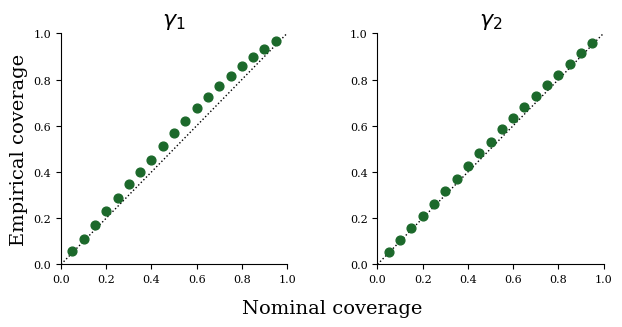

In [11]:
plot_coverage_probs(
    confidence_levels, shear1_coverage_probs, shear2_coverage_probs,
    save_path="figures/npe_coverageprobs_setting2.png"
)

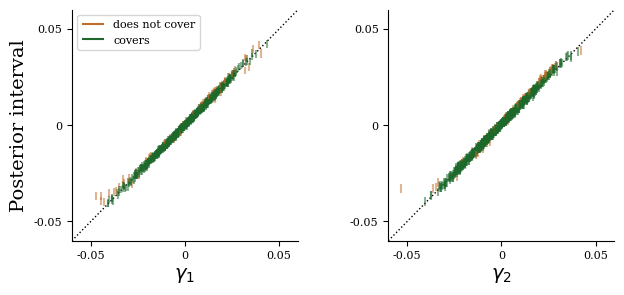

In [12]:
plot_credible_intervals(
    shear1_true, shear2_true,
    shear1_ci_lower, shear1_ci_upper,
    shear2_ci_lower, shear2_ci_upper,
    save_path="figures/npe_credibleintervals_setting2.png"
)

### **Setting 3**

In [13]:
setting3 = torch.load("npe_credible_intervals_setting3.pt", weights_only=False)

confidence_levels = setting3["confidence_levels"]
shear1_true = setting3["shear1_true"]
shear2_true = setting3["shear2_true"]
shear1_ci_lower = setting3["shear1_ci_lower"]
shear1_ci_upper = setting3["shear1_ci_upper"]
shear2_ci_lower = setting3["shear2_ci_lower"]
shear2_ci_upper = setting3["shear2_ci_upper"]

shear1_coverage_probs = compute_coverage_probs(shear1_true, shear1_ci_lower, shear1_ci_upper)
shear2_coverage_probs = compute_coverage_probs(shear2_true, shear2_ci_lower, shear2_ci_upper)

for i, ci in enumerate(confidence_levels):
    print(
        f"Confidence level: {ci:.2f}, Shear 1: {shear1_coverage_probs[i]:.4f}, Shear 2: {shear2_coverage_probs[i]:.4f}"
    )

Confidence level: 0.05, Shear 1: 0.0668, Shear 2: 0.0588
Confidence level: 0.10, Shear 1: 0.1305, Shear 2: 0.1194
Confidence level: 0.15, Shear 1: 0.1942, Shear 2: 0.1838
Confidence level: 0.20, Shear 1: 0.2595, Shear 2: 0.2438
Confidence level: 0.25, Shear 1: 0.3189, Shear 2: 0.3013
Confidence level: 0.30, Shear 1: 0.3762, Shear 2: 0.3550
Confidence level: 0.35, Shear 1: 0.4320, Shear 2: 0.4121
Confidence level: 0.40, Shear 1: 0.4919, Shear 2: 0.4647
Confidence level: 0.45, Shear 1: 0.5449, Shear 2: 0.5191
Confidence level: 0.50, Shear 1: 0.5966, Shear 2: 0.5769
Confidence level: 0.55, Shear 1: 0.6473, Shear 2: 0.6286
Confidence level: 0.60, Shear 1: 0.6999, Shear 2: 0.6795
Confidence level: 0.65, Shear 1: 0.7466, Shear 2: 0.7273
Confidence level: 0.70, Shear 1: 0.7877, Shear 2: 0.7735
Confidence level: 0.75, Shear 1: 0.8273, Shear 2: 0.8194
Confidence level: 0.80, Shear 1: 0.8622, Shear 2: 0.8593
Confidence level: 0.85, Shear 1: 0.8963, Shear 2: 0.8945
Confidence level: 0.90, Shear 1

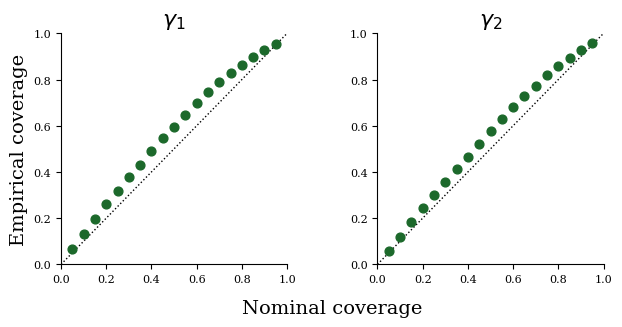

In [14]:
plot_coverage_probs(
    confidence_levels, shear1_coverage_probs, shear2_coverage_probs,
    save_path="figures/npe_coverageprobs_setting3.png"
)

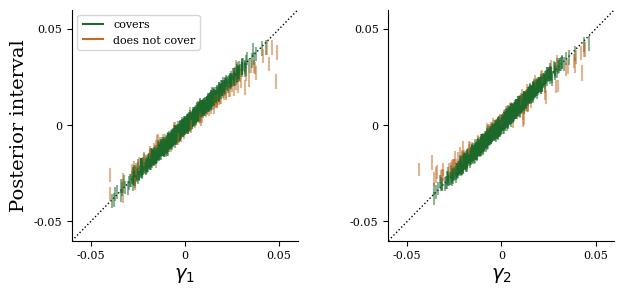

In [15]:
plot_credible_intervals(
    shear1_true, shear2_true,
    shear1_ci_lower, shear1_ci_upper,
    shear2_ci_lower, shear2_ci_upper,
    save_path="figures/npe_credibleintervals_setting3.png"
)

### **Setting 5**

In [16]:
setting5 = torch.load("npe_credible_intervals_setting5.pt", weights_only=False)

confidence_levels = setting5["confidence_levels"]
shear1_true = setting5["shear1_true"]
shear2_true = setting5["shear2_true"]
shear1_ci_lower = setting5["shear1_ci_lower"]
shear1_ci_upper = setting5["shear1_ci_upper"]
shear2_ci_lower = setting5["shear2_ci_lower"]
shear2_ci_upper = setting5["shear2_ci_upper"]

shear1_coverage_probs = compute_coverage_probs(shear1_true, shear1_ci_lower, shear1_ci_upper)
shear2_coverage_probs = compute_coverage_probs(shear2_true, shear2_ci_lower, shear2_ci_upper)

for i, ci in enumerate(confidence_levels):
    print(
        f"Confidence level: {ci:.2f}, Shear 1: {shear1_coverage_probs[i]:.4f}, Shear 2: {shear2_coverage_probs[i]:.4f}"
    )

Confidence level: 0.05, Shear 1: 0.0577, Shear 2: 0.0485
Confidence level: 0.10, Shear 1: 0.1155, Shear 2: 0.1000
Confidence level: 0.15, Shear 1: 0.1727, Shear 2: 0.1536
Confidence level: 0.20, Shear 1: 0.2325, Shear 2: 0.2066
Confidence level: 0.25, Shear 1: 0.2907, Shear 2: 0.2621
Confidence level: 0.30, Shear 1: 0.3504, Shear 2: 0.3133
Confidence level: 0.35, Shear 1: 0.4076, Shear 2: 0.3672
Confidence level: 0.40, Shear 1: 0.4622, Shear 2: 0.4194
Confidence level: 0.45, Shear 1: 0.5202, Shear 2: 0.4693
Confidence level: 0.50, Shear 1: 0.5759, Shear 2: 0.5179
Confidence level: 0.55, Shear 1: 0.6251, Shear 2: 0.5658
Confidence level: 0.60, Shear 1: 0.6724, Shear 2: 0.6135
Confidence level: 0.65, Shear 1: 0.7178, Shear 2: 0.6605
Confidence level: 0.70, Shear 1: 0.7614, Shear 2: 0.7084
Confidence level: 0.75, Shear 1: 0.8026, Shear 2: 0.7573
Confidence level: 0.80, Shear 1: 0.8445, Shear 2: 0.8005
Confidence level: 0.85, Shear 1: 0.8835, Shear 2: 0.8459
Confidence level: 0.90, Shear 1

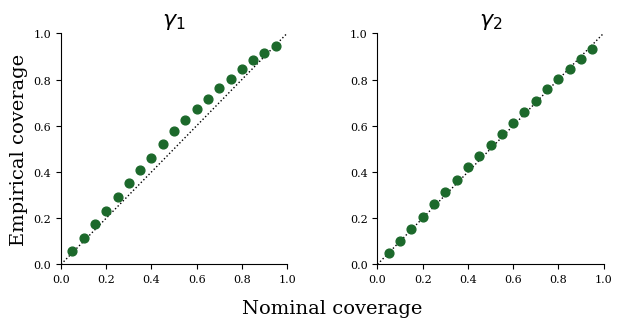

In [17]:
plot_coverage_probs(
    confidence_levels, shear1_coverage_probs, shear2_coverage_probs,
    save_path="figures/npe_coverageprobs_setting5.png"
)

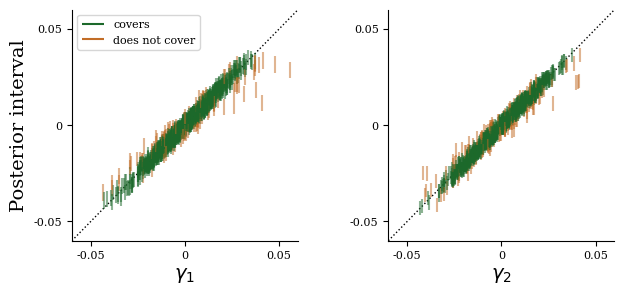

In [18]:
plot_credible_intervals(
    shear1_true, shear2_true,
    shear1_ci_lower, shear1_ci_upper,
    shear2_ci_lower, shear2_ci_upper,
    save_path="figures/npe_credibleintervals_setting5.png"
)